In [2]:
#导入必要的库
import numpy as np 
import pandas as pd 
import cv2
import os
import matplotlib.pyplot as plt

In [64]:
sensor_data = pd.read_csv('F:\\buaa\\python\\final_proj\\data\\mysenior_sensor_data_output.csv')
time_list = pd.to_datetime(sensor_data['Time (UTCG)']).to_list()
time_i = []
#读取generate)star_map.py生成的星图
img_names = os.listdir("F:\\buaa\\python\\final_proj\\image")
ori_imgs = [] #包含所需图片的列表，每张图是原始图像
imgs = [] #包含所需图片的列表，每张图是经过二值化之后的
for i in img_names[:200]:
  imgname = i
  if i == '0000.png':
    time_i.append(time_list[0])
  else:
    time_i.append(time_list[eval(i.strip('0').strip('.png'))])
  img = cv2.imread("F:\\buaa\\python\\final_proj\\image\\" + imgname)
  ori_imgs.append(img)
  blur = cv2.GaussianBlur(img, (5,5), 0)#5*5的高斯滤波
  ret, th = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)#二值化
  gray = cv2.cvtColor(th, cv2.COLOR_BGR2GRAY)#转为灰度图
  imgs.append(gray)

In [65]:
img_all = cv2.GaussianBlur(imgs[0], (5, 5), 0)
ret, thresh = cv2.threshold(img_all, 50,255,cv2.THRESH_BINARY)
img_all = thresh
for i in imgs[:50]:
    img0 = cv2.GaussianBlur(i, (5, 5), 0)
    ret, thresh = cv2.threshold(img0, 50, 255, cv2.THRESH_BINARY)
    img_all = cv2.add(img_all, thresh)
    img_all = np.clip(img_all, 0, 255)
img_all = cv2.cvtColor(img_all, cv2.COLOR_GRAY2BGR)

In [66]:
def get_angle(vec1, vec2):#得到两个向量的夹角（角度制）
    cos = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle = np.arccos(np.clip(cos,-1,1)) * 180 / np.pi
    if np.isnan(angle).any():
        return angle
    angle = float(angle)
    return angle 

In [67]:
# # test from csv to img
# df = pd.read_csv("F:\\buaa\\python\\final_proj\\log_data.csv")
# mask = df["time"] == df.iloc[5237]["time"]
# df = df[mask]
# df = df.reset_index(drop=True)
# img = np.zeros((1400, 1400, 3), dtype=np.uint8)
# for i in range(len(df)):
#     x = int(df.loc[i]["v"])+700
#     y = int(df.loc[i]["u"])+700
#     if x < 0 or x >= 1400 or y < 0 or y >= 1400:
#       print(i)
#     img[y, x] = (255,255,255)
#     cv2.putText(img, str(df.loc[i]["target"]), (x+10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
# img = cv2.resize(img, (700, 700))
# cv2.imwrite("F:\\buaa\\python\\final_proj\\test.png", img)

In [68]:
#Motion类，用于存储运动轨迹，先初始化，然后不断更新轨迹。在需要的时候计算轨迹的方向和角度
class Motion():
  def __init__(self, init_pos, time):
    self.traj = [init_pos]
    self.time = [time]
  
  def update(self, pos, time):
    self.traj.append(pos)
    self.time.append(time)
  
  def traj_direction(self):
    if len(self.traj) < 2:
      self.angle = 0
      self.direction= np.nan
      return np.nan
    direction = []
    for i in range(len(self.traj)-1):
      direction.append(self.traj[i+1] - self.traj[i])
    direction = np.array(direction)
    direction = direction.mean(axis=0)
    self.direction=direction/np.linalg.norm(direction)
    self.angle = get_angle(self.direction, np.array([0, 1]))
    return self.direction
  
  def set_catagory(self,cata):
    self.catagory = cata
  
motions = []
for i in range(50):
  img = imgs[i]
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)#连通域
  for j in range(1, num_labels):#遍历每一个连通域
    flag = False#判断当前连通域是否是某个轨迹的一部分
    for k in range(len(motions)):
      if np.linalg.norm(centroids[j] - motions[k].traj[-1]) < 5: #如果当前连通域与某个轨迹末端距离小于5，那么认为它是这个轨迹的下一步
        motions[k].update(centroids[j], i)#将当前的连通域中心加入轨迹
        flag = True
        break
    if not flag:
      motions.append(Motion(centroids[j], i))# 如果当前连通域不是任何轨迹的一部分，那么新建一个轨迹
print(len(motions))

50


In [69]:
angles = []
img_angle = img_all.copy()
for i in range(len(motions)-1):
  direction = motions[i].traj_direction()
  if np.isnan(direction).any():
    motions.remove(motions[i])
    continue
  angles.append(get_angle(direction, np.array([0,1])))
angles = np.array(angles)
for motion in motions:
  direction = motion.traj_direction()
  if motion.time[-1] - motion.time[0] < 15:
    continue
  angle = get_angle(direction, np.array([0,1]))
  angle = float(angle)  
  cv2.putText(img_angle, "{:.3f}".format(angle), (int(motion.traj[-1][0]+10), int(motion.traj[-1][1])+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
img_angle = cv2.resize(img_angle, (700, 700))
cv2.imwrite("trajey.png", img_angle)
# cv2.imshow("img_all", img_angle)
# cv2.waitKey(0)

True

In [70]:
counts, bin_edges = np.histogram(angles, bins=len(angles)//5)
max_count_index = np.argmax(counts)
most_frequent_interval = (bin_edges[max_count_index], bin_edges[max_count_index + 1])
max_count = counts[max_count_index]
print("most frequent interval: ", most_frequent_interval, "max count: ", max_count, "all count: ", len(angles))
for motion in motions:
  if motion.angle >= most_frequent_interval[0] and motion.angle <= most_frequent_interval[1]:
    motion.set_catagory("star")
  else:
    motion.set_catagory("debris")
    print(motion.angle)

most frequent interval:  (0.0, 8.856338395188775) max count:  46 all count:  47
79.70704555669897


In [71]:
# def get_magnitude(img, stat, centroid):
#   x, y, w, h, area = stat
#   x, y = int(centroid[0]), int(centroid[1])
#   img = img[y-h//2:y+h//2, x-w//2:x+w//2]
#   max_gray = np.max(img)
#   # magnitude = \frac{\lg(1-gray/255)}{\lg2.512}+6
#   print(max_gray)
#   return np.log10(1-max_gray/255)/np.log10(2.512)+6

In [72]:
# 高斯曲面拟合
from scipy.optimize import curve_fit
def gaussian_2d(grid, A, x0, y0, sigma_x, sigma_y, B):
    """二维高斯函数定义"""
    x, y = grid
    exponent = -((x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2))
    return A * np.exp(exponent).ravel() + B

def extract_roi(img, center, window_size=8):
    """提取目标区域"""
    h, w = img.shape
    x, y = int(center[0]), int(center[1])
    pad = window_size//2
    
    # 边界处理
    x_slice = slice(max(0,x-pad), min(h,x+pad+1))
    y_slice = slice(max(0,y-pad), min(w,y+pad+1))
    
    # 生成坐标网格
    xx, yy = np.mgrid[x_slice, y_slice]
    return img[x_slice,y_slice], (xx, yy)
def fit_gaussian(img_roi, grid, initial_guess):
    """带噪声鲁棒的拟合"""
    # 生成权重矩阵（噪声较强区域权重降低）
    weights = 1 / (np.sqrt(np.abs(img_roi)) + 1e-6)
    
    # 参数约束
    bounds = (
        [0, grid[0].min()-2, grid[1].min()-2, 0.1, 0.1, 0],
        [np.inf, grid[0].max()+2, grid[1].max()+2, 10, 10, np.inf]
    )
    popt, pcov = curve_fit(
        lambda grid, A, x0, y0, sig_x, sig_y, B: gaussian_2d(grid, A, x0, y0, sig_x, sig_y, B),
        grid, img_roi.ravel(), p0=initial_guess,
        sigma=weights.ravel(), bounds=bounds
    )
    return popt
def calculate_centroid_Gaussian(img, rough_center):
    """完整质心计算流程"""
    # 步骤1：提取ROI
    roi, grid = extract_roi(img, rough_center)
    # 步骤2：生成初始猜测
    peak_val = roi.max()
    bg_level = np.median(roi)
    initial_guess = [peak_val - bg_level,rough_center[0],rough_center[1],0.5,0.5,bg_level]
    # 步骤3：执行拟合
    try:
        params = fit_gaussian(roi, grid, initial_guess)
        return (params[1], params[2])  # 返回(x0,y0)
    except RuntimeError:
        return rough_center  # 拟合失败时返回初始值
def calculate_centroid_thre(img,rough_center,threshold=50):
    roi, grid = extract_roi(img, rough_center)
    #带阈值的质心法
    mask = roi > threshold
    if np.sum(mask) == 0:
        print("No pixels above threshold")
        return rough_center
    y, x = np.nonzero(mask)
    x0 = np.mean(x)+grid[0].min()
    y0 = np.mean(y)+grid[1].min()
    return (x0, y0)

In [ ]:
star_df = []
debris_df = []
test_centroid = []
for i in range(50,len(imgs)): #len(imgs)
  img = imgs[i]
  ori_img = ori_imgs[i].copy()
  ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
  for j in range(1, num_labels):
    rough_center = (centroids[j][1], centroids[j][0])

    # 这里两行代码中二选一注释掉，以选择不同的质心计算方法（普通的或者高斯的）
    # refined_center = rough_center
    refined_center = calculate_centroid_Gaussian(ori_img, rough_center)

    for k in range(len(motions)):
      if np.linalg.norm(centroids[j] - motions[k].traj[-1]) < 2:
        if motions[k].catagory == "star":
          # star_df.append({"time": i, "u": refined_center[0], "v": refined_center[1], "target": k})
          star_df.append({"time": time_i[i], "u": refined_center[0], "v": refined_center[1], "target": k})
          motions[k].update(centroids[j], i)
        elif motions[k].catagory == "debris":
          print(num_labels)
          print(time_i[i],k," refined_center: ", refined_center," rough_center: ", rough_center, ori_img[int(refined_center[0]), int(refined_center[1])],ori_img[int(refined_center[1]), int(refined_center[0])])
          test_centroid.append({"time": time_i[i], "u": centroids[j][0], "v": centroids[j][1], "u_Gauss":refined_center[0], "v_Gauss":refined_center[1], "target": k})
          debris_df.append({"time": time_i[i], "u": refined_center[0], "v": refined_center[1], "target": k})
          motions[k].update(centroids[j], i)
        break
star_df = pd.DataFrame(star_df)
debris_df = pd.DataFrame(debris_df)

C:\Users\clyde\AppData\Local\Temp\ipykernel_39732\4261542147.py:25: RuntimeWarning: overflow encountered in divide
  weights = 1 / (np.sqrt(np.abs(img_roi)) + 1e-6)


48
2023-04-25 16:00:05 35  refined_center:  (884.5078131340567, 884.2154343340926)  rough_center:  (884.7142857142857, 884.0) 149 149
48
2023-04-25 16:00:05.100000 35  refined_center:  (884.6876200189309, 884.8258297166333)  rough_center:  (884.875, 884.875) 46 46
48
2023-04-25 16:00:05.200000 35  refined_center:  (884.860019986427, 885.4644143922203)  rough_center:  (885.0, 885.2857142857143) 72 1
48
2023-04-25 16:00:05.300000 35  refined_center:  (884.7988404853129, 885.8531609954589)  rough_center:  (885.0, 886.0) 28 0
48
2023-04-25 16:00:05.400000 35  refined_center:  (884.7740443307542, 886.5607156623593)  rough_center:  (885.0, 886.5) 38 0
48
2023-04-25 16:00:05.500000 35  refined_center:  (885.0411050967097, 887.4207254225432)  rough_center:  (885.0, 887.2857142857143) 226 0
48
2023-04-25 16:00:05.600000 35  refined_center:  (885.3533257891203, 887.6082983306959)  rough_center:  (885.0, 887.7142857142857) 74 4
48
2023-04-25 16:00:05.700000 35  refined_center:  (885.2795393859897

In [80]:
star_df.to_csv("F:\\buaa\\python\\final_proj\\star_data.csv", index=False)
debris_df.to_csv("F:\\buaa\\python\\final_proj\\debris_data.csv", index=False)
test_centroid = pd.DataFrame(test_centroid)
test_centroid.to_csv("F:\\buaa\\python\\final_proj\\test_centroid.csv", index=False)

In [81]:
img50 = imgs[50]
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img50, 4, cv2.CV_32S)
img50 = cv2.cvtColor(img50, cv2.COLOR_GRAY2BGR)
for j in range(1, num_labels):
    for k in range(len(motions)):
      if np.linalg.norm(centroids[j] - motions[k].traj[-1]) < 2:
        # if motions[k].catagory == "star":
        #   cv2.putText(img50, "star{}".format(k), (int(centroids[j][0]+10), int(centroids[j][1])+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        if motions[k].catagory == "debris":
          print(k)
          cv2.putText(img50, "debris{}".format(k), (int(centroids[j][0]+10), int(centroids[j][1])+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        break
img50 = cv2.resize(img50, (700, 700))
cv2.imshow("img50", img50)
cv2.waitKey(0)

-1

u error:  0.41423971298395457
v error:  0.3838634836650633
u Gaussian error:  0.34080021873320876
v Gaussian error:  0.3280163820610101
centroids:  0.7981031966490181
Gaussian:  0.668816600794219


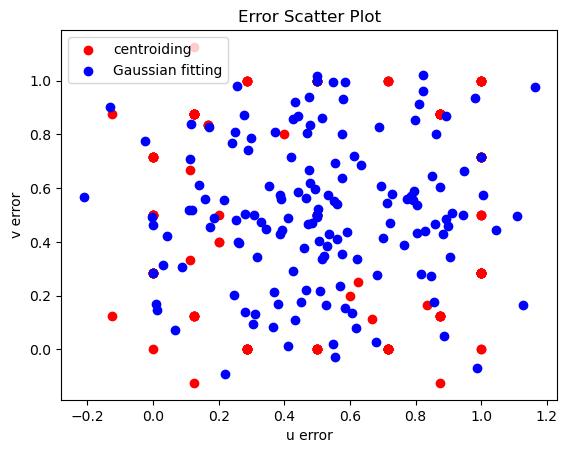

u error:  0.5244100529100532 0.37314046871229317
v error:  0.4886137566137624 0.3809462961007106
u Gaussian error:  0.5109477346893065 0.28236967108575045
v Gaussian error:  0.5080640868984126 0.2643619973920084


In [10]:
# validation for gaussian
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="SimHei.ttf", size=14)
center = pd.read_csv("F:\\buaa\\python\\final_proj\\test_centroid.csv")
center['time'] = pd.to_datetime(center['time'])
center = center[center['target']==35].reset_index(drop=True)
time_ls = center['time'].to_list()
true_center = pd.read_csv("F:\\buaa\\python\\final_proj\\log_data0.csv")
true_center['time'] = pd.to_datetime(true_center['time'])
true_center = true_center[true_center['target']=='METEOR_1-15_06659']
true_center = true_center[true_center['time'].isin(time_ls)]
true_center = true_center.drop(columns=['target','debris_num','star_num','magnitude','category']).reset_index(drop=True)
u_error = []
v_error = []
u_g_error = []
v_g_error = []
for i in range(len(center)):
  u_true = float(true_center.loc[i]["u"])+700
  v_true = float(true_center.loc[i]["v"])+700
  u = center.loc[i]["v"].astype(float)
  v = center.loc[i]["u"].astype(float)
  u_g = center.loc[i]["u_Gauss"].astype(float)
  v_g = center.loc[i]["v_Gauss"].astype(float)
  u_error.append(u - u_true)
  v_error.append(v - v_true)
  u_g_error.append(u_g - u_true)
  v_g_error.append(v_g - v_true)
u_error = np.array(u_error)
v_error = np.array(v_error)
u_g_error = np.array(u_g_error)
v_g_error = np.array(v_g_error)

print("u error: ", np.mean(u_error**2))
print("v error: ", np.mean(v_error**2))
print("u Gaussian error: ", np.mean(u_g_error**2))
print("v Gaussian error: ", np.mean(v_g_error**2))
print('centroids: ',np.mean(u_error**2+v_error**2))
print('Gaussian: ',np.mean(u_g_error**2+v_g_error**2))
plt.scatter(u_error, v_error, c='r', label='centroiding')
plt.scatter(u_g_error, v_g_error, c='b', label='Gaussian fitting')
plt.xlabel('u error')
plt.ylabel('v error')
plt.title('Error Scatter Plot')
plt.legend()
plt.show()
print("u error: ", np.mean(u_error), np.std(u_error))
print("v error: ", np.mean(v_error), np.std(v_error))
print("u Gaussian error: ", np.mean(u_g_error), np.std(u_g_error))
print("v Gaussian error: ", np.mean(v_g_error), np.std(v_g_error))

In [5]:
columns = ['u error', 'v error', 'u Gaussian error', 'v Gaussian error']
data = {
    'u error': u_error,
    'v error': v_error,
    'u Gaussian error': u_g_error,
    'v Gaussian error': v_g_error
}
df = pd.DataFrame(data, columns=columns)
df.to_csv("plot_data/centroids.csv", index=False)